# Kirk Evaluation Protocol 2.0
First, generate train and test contexts.
Then run commands down below.

## Create Train/Test Contexts

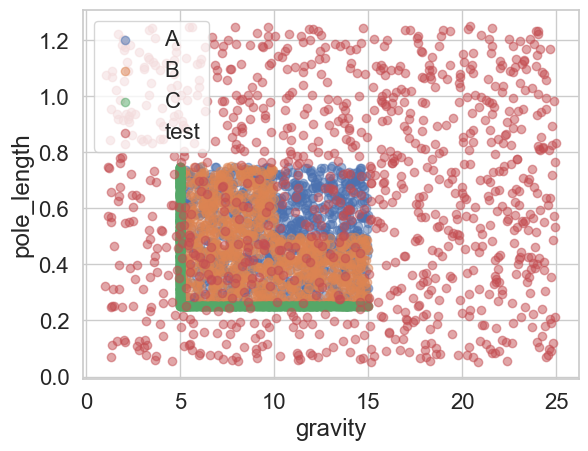

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
from experiments.common.utils.json_utils import lazy_json_dump

 
env_name = "CARLCartPoleEnv"
seed = 6847
n_samples_train = 1000
n_samples_test = 1000

bounds = {
    "gravity": {
        "train": [5, 15],
        "test": [1, 25]
    },
    "pole_length": {
        "train": [0.25, 0.75],
        "test": [0.05, 1.25],
    }
}

# bounds = {
#     "update_interval": {
#         "train": [0.01, 0.03],
#         "test": [0.002, 0.04]
#     },
#     "pole_length": {
#         "train": [0.25, 0.75],
#         "test": [0.05, 1.25],
#     }
# }

# bounds = {
#     "update_interval": {
#         "train": [0.01, 0.03],
#         "test": [0.002, 0.04]
#     },
#     "gravity": {
#         "train": [5, 15],
#         "test": [1, 25]
#     },
# }

identifier = "_".join(list(bounds.keys()))

outdir = Path("data/kirk_ep") / env_name / identifier
outdir.mkdir(exist_ok=True, parents=True)


def get_contexts(bounds: dict[str, dict[str, list[float]]], mode: str = "A", seed: int = None) -> tuple[dict, np.ndarray]:

    # Create train context set
    rng = np.random.default_rng(seed=seed)
    B = np.array([b["train"] for cf, b in bounds.items()])
    cfs = list(bounds.keys())
    contexts = {}
    if mode == "A":
        X = np.array([rng.uniform(*B[i], size=n_samples_train) for i in range(len(B))])
    elif mode == "B":
        n = n_samples_train // 3
        n2 = n_samples_train - n

        B_ = B.copy()
        B_[1, 1] = np.mean(B_[1])   
        x1 =  np.array([rng.uniform(*B_[i], size=n2) for i in range(len(B))])

        B_ = B.copy()
        B_[0, 1] = np.mean(B_[0])
        B_[1, 0] = np.mean(B_[1])
        x2 = np.array([rng.uniform(*B_[i], size=n) for i in range(len(B))])

        X = np.concatenate([x1, x2], axis=1)
    elif mode == "C":
        n = n_samples_train // 2

        X = []
        for i in range(len(B)):
            B_ = B.copy()
            B_[i, 1] = B_[i, 0]
            x =  np.array([rng.uniform(*B_[i], size=n) for i in range(len(B))])
            X.append(x)

        X = np.concatenate(X, axis=1)

    elif mode == "test":
        B = np.array([b["test"] for cf, b in bounds.items()])
        X = np.array([rng.uniform(*B[i], size=n_samples_train) for i in range(len(B))])

    else:
        raise NotImplementedError

    contexts = {i: {cf: X[j,i] for j, cf in enumerate(cfs)} for i in range(X.shape[1])}  

    return contexts, X

modes = ["A", "B", "C", "test"]


for mode in modes:
    contexts, X = get_contexts(bounds=bounds, mode=mode, seed=seed)

    lazy_json_dump(contexts, outdir / f"contexts_{mode}.json")

    plt.scatter(*X, label=mode, alpha=0.5)


plt.legend()

cfs = list(bounds.keys())
plt.xlabel(cfs[0])
plt.ylabel(cfs[1])
plt.show()




## Command

Run:
`python experiments/benchmarking/run_training.py +experiments=kirk_ep +experiments/ep/mode=A,B,C 'seed=range(1,11)' '+context_visibility=hidden,visible_all,cgate_hadamard' -m `

More env steps, less visibilities, cpu normal:
`python experiments/benchmarking/run_training.py +experiments=kirk_ep max_num_frames=500000 +slurm=cpu hydra.launcher.timeout_min=300 +experiments/ep/mode=A,B,C 'seed=range(1,11)' '+context_visibility=hidden,visible_all' -m`

Standard, but pole length and update interval (need to regenerate context files)
`python experiments/benchmarking/run_training.py +experiments=kirk_ep  +experiments/ep/mode=A,B,C 'seed=range(1,11)' '+context_visibility=hidden,visible_all' -m`

Evaluate:
`python experiments/evaluation/run_evaluation.py 'n_eval_episodes_per_context=5' 'experiment=kirk_eval_ep' 'contexts_path=/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/experiments/evaluation/data/kirk_ep/CARLCartPoleEnv/contexts_test.json' -m --result_dir '/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/exp_sweep/2023-02-17/07-52-33_benchmark_train'`


500k steps (experiment=kirk_ep3)
result dir 1: /home/benjamin/Dokumente/code/tmp/tntcomp/CARL/exp_sweep/2023-02-23/08-23-56_benchmark_train

100k kirk_ep4 update_interval, pole_length
result dir: /home/benjamin/Dokumente/code/tmp/tntcomp/CARL/exp_sweep/2023-03-30/16-33-35_benchmark_train

100k kirk_ep4 update_interval + gravity
/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/exp_sweep/2023-04-03/18-59-11_benchmark_train

100k kirk_ep5, update_interval + gravity, gaussian noise on context features
/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/exp_sweep/2023-04-04/10-46-17_benchmark_train
/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2023-04-04/13-54-18

## Load Eval Data

In [9]:
from multiprocessing import Pool

folders_eval = [
    # "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2023-02-17/13-25-22"  # eval on train  DONT USE BOTH CANT DIFFERENTIATE
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2023-02-20/09-52-51",  # eval on test, 100k training steps, pole_length + gravity
    # "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2023-02-23/16-39-42",  # eval on test, 500k training steps
    # "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2023-03-31/10-36-40",   # eval on test, 100k, update_interval + pole_length
    # "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2023-04-04/08-32-10",   # eval on test, 100k, update_interval + gravity
    # "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2023-04-04/13-54-18",   # eval on test, 100k, update_interval + gravity, gaussian noise on context features
]

import pandas as pd
import experiments.evaluation.loading
from importlib import reload
reload(experiments.evaluation.loading)


rpc_fn = outdir / "rpc.csv"
reload = False

print(rpc_fn)

# with Pool(processes=None) as pool:
#     results = pool.map(fn, paths)
df = pd.concat([experiments.evaluation.loading.load(folder_eval=folder_eval, rpc_fn=rpc_fn, load_from_path=experiments.evaluation.loading.load_from_path_eval, reload_rpc=reload) for folder_eval in folders_eval]).reset_index(drop=True)


from rich import print as printr

data/kirk_ep/CARLCartPoleEnv/gravity_pole_length/rpc.csv


## Discretize Context Features

In [10]:
cfs = list(bounds.keys())
n_bins = 20
cf_bins = {}
for cf in cfs:
    precision = 3
    if cf == "gravity":
        precision = 1
    bin_idx, bins = pd.cut(df[cf], bins=n_bins, include_lowest=True, retbins=True, labels=False)
    labels, bins = pd.cut(df[cf], bins=n_bins, include_lowest=True, retbins=True, precision=precision)
    cf_bins[cf] = bins
    df[cf + "_bin_idx"] = bin_idx
    df[cf + "_bin_lbl"] = labels

    


## Plot Heatmaps

In [11]:
from scipy.stats import trim_mean
import seaborn as sns
from matplotlib.patches import Rectangle, Polygon, PathPatch
import matplotlib as mpl


def get_polygon_patch(mode, V, H):
    if mode == "A":
        polygon = np.array([
            [H[0], V[0]],
            [H[0], V[2]],
            [H[2], V[2]],
            [H[2], V[0]],
        ])
        patch = Polygon(xy=polygon, **patch_kwargs)
    elif mode == "B":
        polygon = np.array([
            [H[0], V[0]],
            [H[0], V[2]],
            [H[1], V[2]],
            [H[1], V[1]],
            [H[2], V[1]],
            [H[2], V[0]],
        ])
        patch = Polygon(xy=polygon, **patch_kwargs)
    elif mode == "C":
        polygon = np.array([
            [H[2], V[0]],
            [H[0], V[0]],
            [H[0], V[2]],
            # [H[0], V[0]],
            # [H[2], V[0]],
            [H[0] + 1, V[2]],
            [H[0] + 1, V[0] + 1],
            [H[2], V[0] + 1],
        ])
        patch = Polygon(xy=polygon, **patch_kwargs)
    else:
        patch = None
    return patch


sns.set(font_scale=1.45)
sns.set_style("whitegrid")


plot_combined = True
df = df[df["visibility"].isin(["hidden", "concat (all)"])]

visibilities = list(df["visibility"].unique())
modes = list(df["mode"].unique())
agg_fun = lambda x: trim_mean(x["return"], proportiontocut=0.25)
agg_fun = lambda x: np.mean(x["return"])

from rliable import library as rly
from rliable import metrics
import importlib
import rliable.plot_utils
importlib.reload(rliable.plot_utils)

def agg_fun(x):
    reps = 10000
    metric_names = ['Mean']  # ['Median', 'IQM', 'Mean']  # , 'Optimality Gap']
    aggregate_func = lambda x: np.array([
    #   metrics.aggregate_median(x),
    #   metrics.aggregate_iqm(x),
    metrics.aggregate_mean(x),
    #   metrics.aggregate_optimality_gap(x)
    ])
    score_dict = {}
    # print(x["context_id"].unique())
    # print(list(x.groupby(by="context_id")))
    # print(x["seed"].unique())
    R = x.groupby("seed").apply(lambda x: np.mean(x["return"])).to_numpy()
    R = R.reshape((-1, 1))
    # print(R.shape)
    score_dict["dummy"] = R
    # print(score_dict["dummy"])
    aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
            score_dict, aggregate_func, reps=reps)
    # print(aggregate_scores, aggregate_score_cis)
    # raise
    # exit()

    return aggregate_scores["dummy"][0]


hm_long = df.groupby(by=[cf + "_bin_idx" for cf in cfs]+ ["visibility", "mode"]).apply(agg_fun)

heatmap = np.zeros((n_bins, n_bins, len(visibilities), len(modes)))
for idx in hm_long.index:
    i, j, v, m = idx
    v = visibilities.index(v)
    m = modes.index(m)
    # if i == 0 and j == 1:
    #     print(visibilities[v], modes[m], hm_long[idx])
    heatmap[i, j, v, m] = hm_long[idx]



data/kirk_ep/CARLCartPoleEnv/gravity_pole_length/heatmap_combined.pdf


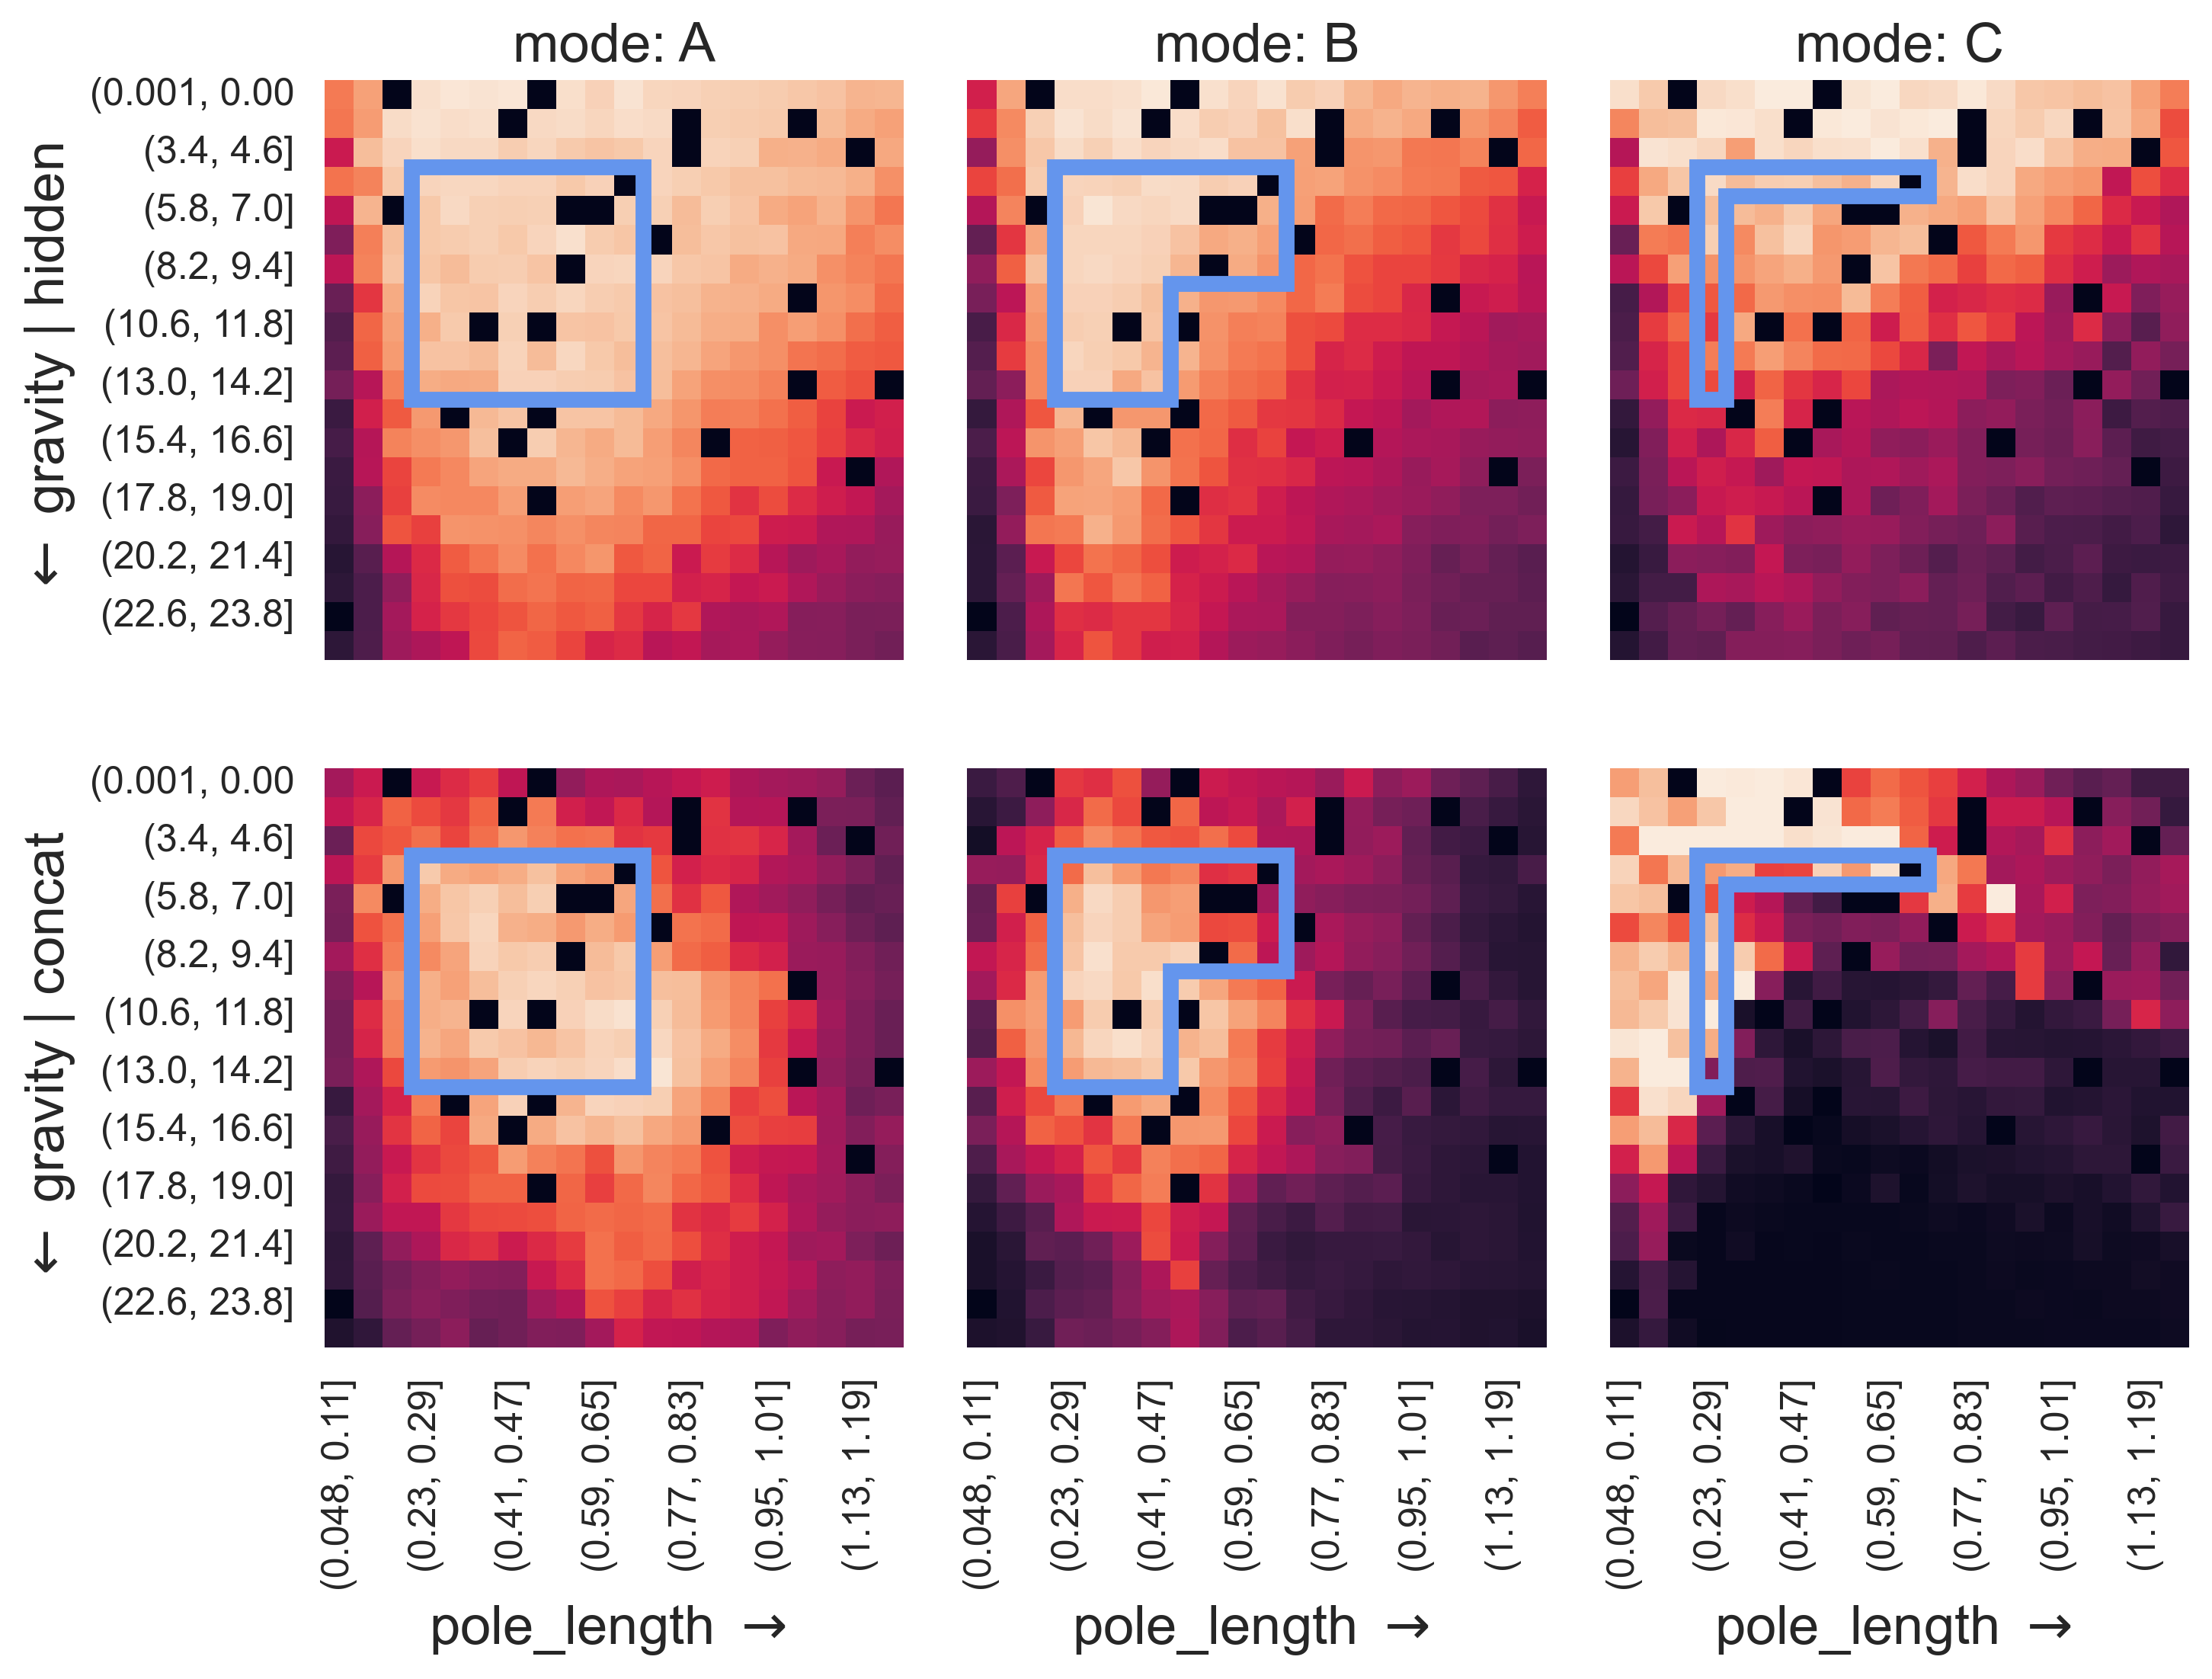

In [12]:


xbinlabels = list(df[cfs[1] + "_bin_lbl"].unique())
ybinlabels = list(df[cfs[0] + "_bin_lbl"].unique())

xlabel = cfs[1]  # col
ylabel = cfs[0]  # row

xbounds = bounds[cfs[1]]["train"]
ybounds = bounds[cfs[0]]["train"]

vlines = [xbounds[0], np.mean(xbounds), xbounds[1]]
hlines = [ybounds[0], np.mean(ybounds), ybounds[1]]

vlines = pd.cut(vlines, bins=cf_bins[cfs[1]], include_lowest=True, retbins=False, labels=False)
hlines = pd.cut(hlines, bins=cf_bins[cfs[0]], include_lowest=True, retbins=False, labels=False)

xbinlabels.sort()
ybinlabels.sort()

patch_kwargs = {"fill": False, "linewidth": 5, "color": "cornflowerblue"}

skip_ticks = 2

if plot_combined:
    fig = plt.figure(figsize=(10, 8), dpi=300)
    axes = fig.subplots(nrows=len(visibilities), ncols=len(modes), sharex=True, sharey=True)
    for v in range(heatmap.shape[-2]):
        for m in range(heatmap.shape[-1]):
            mode = modes[m]
            
            V = vlines
            H = hlines
            mode = modes[m]
            patch = get_polygon_patch(mode, V, H)
            
            X = heatmap[:, :, v, m]
            # X[X < 495] = 0
            ax = axes[v, m]
            ax = sns.heatmap(data=X, vmin=0, vmax=500, annot=False, fmt=".0f", annot_kws=dict(fontsize='xx-small'), ax=ax, cbar=False) #  cbar=True if m==len(modes) - 1 else False)

            vis = visibilities[v]
            mode = modes[m]
            
            xticklabels = np.array([str(x) for x in xbinlabels])
            ids = [int(xl.get_text()) for xl in ax.get_xticklabels()]
            ax.set_xticklabels(list(xticklabels[ids]), fontsize='x-small', rotation=90)
            
            yticklabels = np.array([str(x) for x in ybinlabels])
            yticklabels[0] = "(0.001, 0.00391]"
            # ids = [int(xl.get_text()) for xl in ax.get_yticklabels()]
            ids = np.arange(0, X.shape[0], skip_ticks)
            yticks = ids + 0.5
            ax.set_yticks(yticks)
            ax.set_yticklabels(list(yticklabels[ids]), fontsize='x-small', rotation=0)

            if m == 0:
                ax.set_ylabel(r"$\leftarrow$ " + ylabel + f" | {vis.replace('concat (all)', 'concat')}")

            if v == 0:
                ax.set_title(f"mode: {mode}")

            if v == len(visibilities) - 1:
                ax.set_xlabel(xlabel + r" $\rightarrow$ ")
            
            ax.set_aspect("equal")
            ax.add_patch(patch)
            
    fig.set_tight_layout(True)
    fig_fn = outdir / f"heatmap_combined.pdf"
    fig.savefig(fig_fn, bbox_inches="tight", dpi=300)
    print(fig_fn)
    plt.show()

else:
    for v in range(heatmap.shape[-2]):
        fig = plt.figure(figsize=(10, 8), dpi=300)
        axes = fig.subplots(nrows=1, ncols=len(modes))
        for m in range(heatmap.shape[-1]):
            mode = modes[m]
            
            V = vlines
            H = hlines
            mode = modes[m]
            patch = get_polygon_patch(mode, V, H)
            
            X = heatmap[:, :, v, m]
            ax = axes[m]
            ax = sns.heatmap(data=X, vmin=0, vmax=500, annot=False, fmt=".0f", annot_kws=dict(fontsize='xx-small'), ax=ax, cbar=False) #  cbar=True if m==len(modes) - 1 else False)

            vis = visibilities[v]
            mode = modes[m]
            print(vis)
            ax.set_title(f"mode: {mode}")

            xticklabels = np.array([str(x) for x in xbinlabels])
            ids = [int(xl.get_text()) for xl in ax.get_xticklabels()]
            ax.set_xticklabels(list(xticklabels[ids]), fontsize='xx-small', rotation=90)

            
            if m == 0:
                ax.set_ylabel(r"$\leftarrow$ " + ylabel)

                yticklabels = np.array([str(x) for x in ybinlabels])
                ids = [int(xl.get_text()) for xl in ax.get_yticklabels()]
                ax.set_yticklabels(list(yticklabels[ids]), fontsize='xx-small', rotation=0)
            else:
                ax.set_ylabel(None)
                ax.set_yticklabels(["" for y in ybinlabels])
            ax.set_xlabel(xlabel + r" $\rightarrow$ ")
            
            ax.set_aspect("equal")

            ax.add_patch(patch)
            
        fig.set_tight_layout(True)
        fig_fn = outdir / f"heatmap_{vis}.pdf"
        fig.savefig(fig_fn, bbox_inches="tight", dpi=300)
        print(fig_fn)
        plt.show()






## Plot Colorbar

/tmp/ipykernel_19706/4155390871.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.savefig(fig_fn, bbox_inches="tight", dpi=300)
/home/benjamin/.conda/envs/carl/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  func(*args, **kwargs)
/home/benjamin/.conda/envs/carl/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


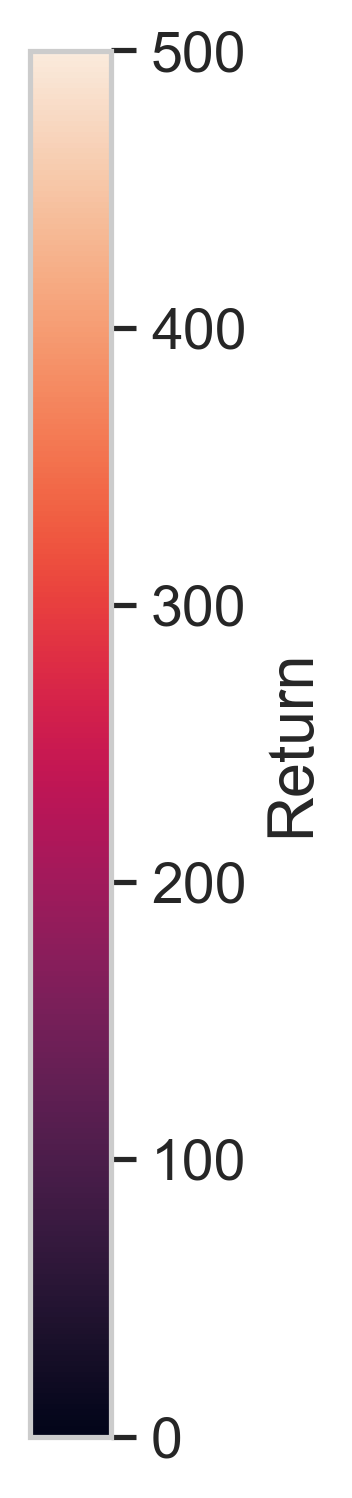

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

sns.set(font_scale=1.25)
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(0.35, 6), dpi=300)
# fig.subplots_adjust(bottom=0.5)

# cmap = mpl.cm.rocket
cmap = sns.color_palette("rocket", as_cmap=True)
norm = mpl.colors.Normalize(vmin=0, vmax=500)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='vertical', label='Return')
fig.set_tight_layout(True)
fig_fn = outdir / "heatmap_cmap.pdf"
fig.savefig(fig_fn, bbox_inches="tight", dpi=300)